In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## **Preprocessing**

In [4]:
import os

# Set up base path
base_dir = '/content/drive/MyDrive/medicinal_plants/data'

# Get list of plant folders, excluding '.ipynb_checkpoints'
plant_folders = [f for f in os.listdir(base_dir)
                 if os.path.isdir(os.path.join(base_dir, f)) and f != '.ipynb_checkpoints']

# Print plant folders for verification
print("Plant folders:", plant_folders)

# Set up paths for each split
train_dirs = [os.path.join(base_dir, plant, 'Train') for plant in plant_folders]
validation_dirs = [os.path.join(base_dir, plant, 'Validation') for plant in plant_folders]
test_dirs = [os.path.join(base_dir, plant, 'Test') for plant in plant_folders]

Plant folders: ['Aloe barbadensis', 'Catharanthus roseus', 'Citrus Limon', 'Mangifera indica', 'Moringa oleifera', 'Psidium guajava', 'Zingiber officianale']


In [5]:
# Print paths for verification
print("Train directories:", train_dirs)
print("Validation directories:", validation_dirs)
print("Test directories:", test_dirs)

Train directories: ['/content/drive/MyDrive/medicinal_plants/data/Aloe barbadensis/Train', '/content/drive/MyDrive/medicinal_plants/data/Catharanthus roseus/Train', '/content/drive/MyDrive/medicinal_plants/data/Citrus Limon/Train', '/content/drive/MyDrive/medicinal_plants/data/Mangifera indica/Train', '/content/drive/MyDrive/medicinal_plants/data/Moringa oleifera/Train', '/content/drive/MyDrive/medicinal_plants/data/Psidium guajava/Train', '/content/drive/MyDrive/medicinal_plants/data/Zingiber officianale/Train']
Validation directories: ['/content/drive/MyDrive/medicinal_plants/data/Aloe barbadensis/Validation', '/content/drive/MyDrive/medicinal_plants/data/Catharanthus roseus/Validation', '/content/drive/MyDrive/medicinal_plants/data/Citrus Limon/Validation', '/content/drive/MyDrive/medicinal_plants/data/Mangifera indica/Validation', '/content/drive/MyDrive/medicinal_plants/data/Moringa oleifera/Validation', '/content/drive/MyDrive/medicinal_plants/data/Psidium guajava/Validation', '/

## **Setting up parameters and data generators**

In [6]:
# Set up parameters
img_size = (224, 224)
batch_size = 64 #was originally 32
num_classes = len(plant_folders)
epochs = 10 # reduced from 30

In [7]:
import numpy as np
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array

class CustomDataGenerator(Sequence):
    def __init__(self, directories, batch_size, target_size, class_mode='categorical', shuffle=True):
        self.directories = directories
        self.batch_size = batch_size
        self.target_size = target_size
        self.class_mode = class_mode
        self.shuffle = shuffle

        self.classes = [os.path.basename(os.path.dirname(d)) for d in directories]
        self.class_indices = {cls: idx for idx, cls in enumerate(self.classes)}

        self.filenames = []
        for d in directories:
            self.filenames.extend([os.path.join(d, f) for f in os.listdir(d) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

        self.num_classes = len(self.classes)
        self.indices = np.arange(len(self.filenames))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_filenames = [self.filenames[i] for i in batch_indices]

        X = np.array([
            img_to_array(load_img(f, target_size=self.target_size)) / 255.0
            for f in batch_filenames
        ])

        if self.class_mode == 'categorical':
            y = np.array([
                self.class_indices[os.path.basename(os.path.dirname(os.path.dirname(f)))]
                for f in batch_filenames
            ])
            y = np.eye(self.num_classes)[y]
        elif self.class_mode == 'binary':
            y = np.array([
                self.class_indices[os.path.basename(os.path.dirname(os.path.dirname(f)))]
                for f in batch_filenames
            ])
        else:
            y = None

        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

# Create generators
train_generator = CustomDataGenerator(train_dirs, batch_size, img_size)
validation_generator = CustomDataGenerator(validation_dirs, batch_size, img_size)
test_generator = CustomDataGenerator(test_dirs, batch_size, img_size)

# Print class indices
print("Class indices:", train_generator.class_indices)

# Invert the dictionary to map indices to class names
idx_to_class = {v: k for k, v in train_generator.class_indices.items()}
print("Index to class mapping:", idx_to_class)

# Calculate steps per epoch
steps_per_epoch = len(train_generator)
validation_steps = len(validation_generator)

Class indices: {'Aloe barbadensis': 0, 'Catharanthus roseus': 1, 'Citrus Limon': 2, 'Mangifera indica': 3, 'Moringa oleifera': 4, 'Psidium guajava': 5, 'Zingiber officianale': 6}
Index to class mapping: {0: 'Aloe barbadensis', 1: 'Catharanthus roseus', 2: 'Citrus Limon', 3: 'Mangifera indica', 4: 'Moringa oleifera', 5: 'Psidium guajava', 6: 'Zingiber officianale'}


## **Training the model**

In [8]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.regularizers import l2

# Load pre-trained MobileNet model
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add new layers
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a dropout layer after GlobalAveragePooling2D
x = Dropout(0.5)(x)

# Add L2 regularization and reduce neurons
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)

# Add another dropout layer
x = Dropout(0.3)(x)

output = Dense(num_classes, activation='softmax')(x)

17225924/17225924 [==============================] - 0s 0us/step


In [9]:
# Create the final model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
# Print model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128   

In [11]:
# Calculate total number of samples
train_samples = sum([len(os.listdir(d)) for d in train_dirs])
val_samples = sum([len(os.listdir(d)) for d in validation_dirs])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=val_samples // batch_size,
    verbose=1
)

Epoch 1/10
37/37 [==============================] - 642s 17s/step - loss: 3.4349 - accuracy: 0.5328 - val_loss: 2.4210 - val_accuracy: 0.8555
Epoch 2/10
37/37 [==============================] - 156s 4s/step - loss: 2.2982 - accuracy: 0.8041 - val_loss: 1.7986 - val_accuracy: 0.9336
Epoch 3/10
37/37 [==============================] - 167s 5s/step - loss: 1.8167 - accuracy: 0.8544 - val_loss: 1.4512 - val_accuracy: 0.9453
Epoch 4/10
37/37 [==============================] - 168s 5s/step - loss: 1.4846 - accuracy: 0.8836 - val_loss: 1.1883 - val_accuracy: 0.9590
Epoch 5/10
37/37 [==============================] - 168s 5s/step - loss: 1.2422 - accuracy: 0.8925 - val_loss: 0.9982 - val_accuracy: 0.9629
Epoch 6/10
37/37 [==============================] - 170s 5s/step - loss: 1.0601 - accuracy: 0.9073 - val_loss: 0.8622 - val_accuracy: 0.9492
Epoch 7/10
37/37 [==============================] - 171s 5s/step - loss: 0.9201 - accuracy: 0.9086 - val_loss: 0.7456 - val_accuracy: 0.9609
Epoch 8/10
3

## **Evaluating the Model**

In [12]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy:.2f}")

9/9 [==============================] - 120s 14s/step - loss: 0.5425 - accuracy: 0.9582
Test accuracy: 0.96


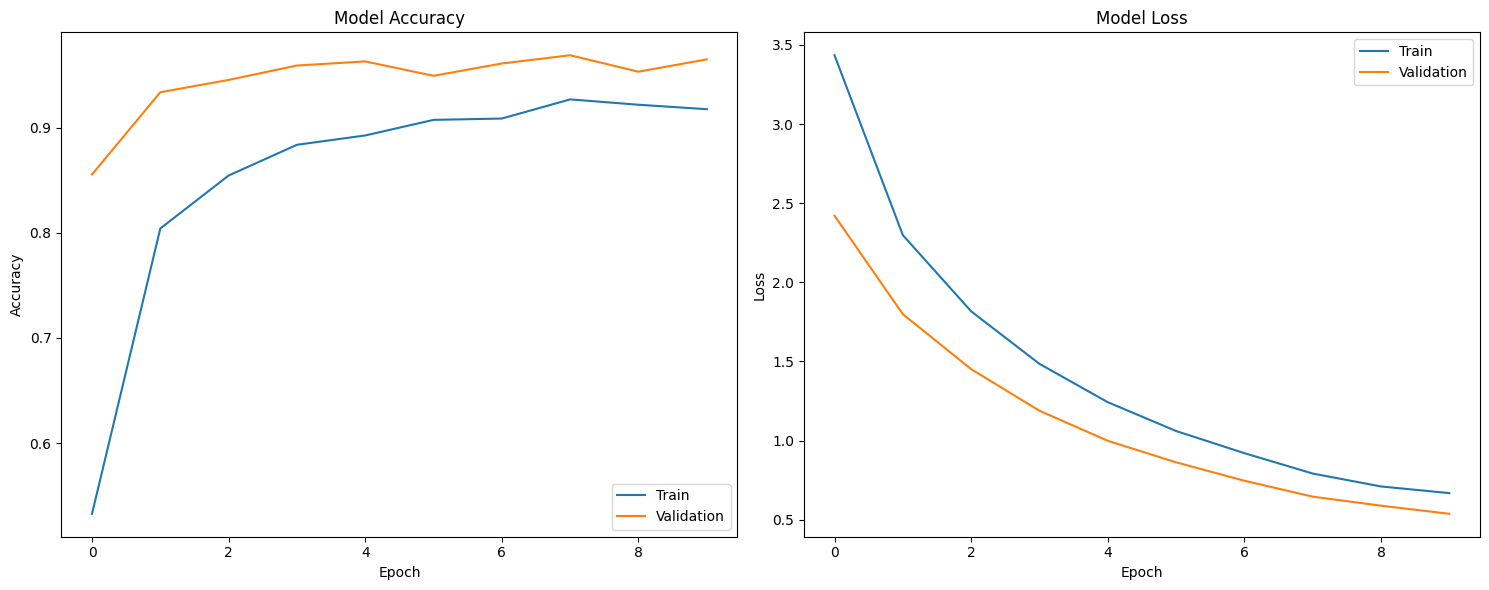

In [19]:
import matplotlib.pyplot as plt

# Assuming you have stored the history in a variable called 'history'
# If not, you'll need to capture the return value of model.fit()
# history = model.fit(...)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot training & validation accuracy values
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='lower right')

# Plot training & validation loss values
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

1/1 [==============================] - 1s 993ms/step


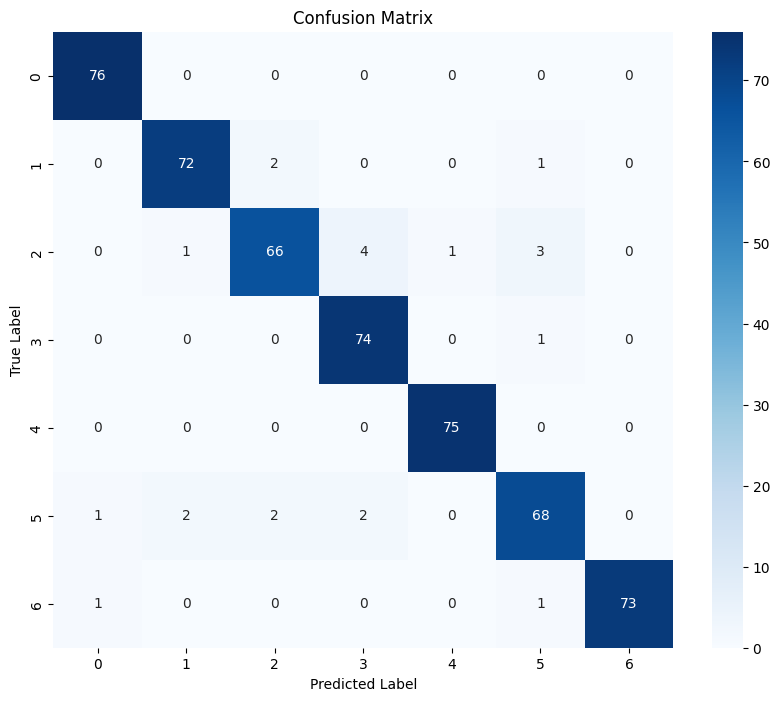

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming your custom generator is called 'test_generator'

# Get the true labels
y_true = []
y_pred = []

# Iterate through the entire dataset
for i in range(len(test_generator)):
    x, y = test_generator[i]
    batch_pred = model.predict(x)
    y_true.extend(np.argmax(y, axis=1))
    y_pred.extend(np.argmax(batch_pred, axis=1))

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Get class names (you might need to provide these manually if not available in the generator)
class_names = list(range(num_classes))  # Replace with actual class names if available

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

1/1 [==============================] - 1s 503ms/step


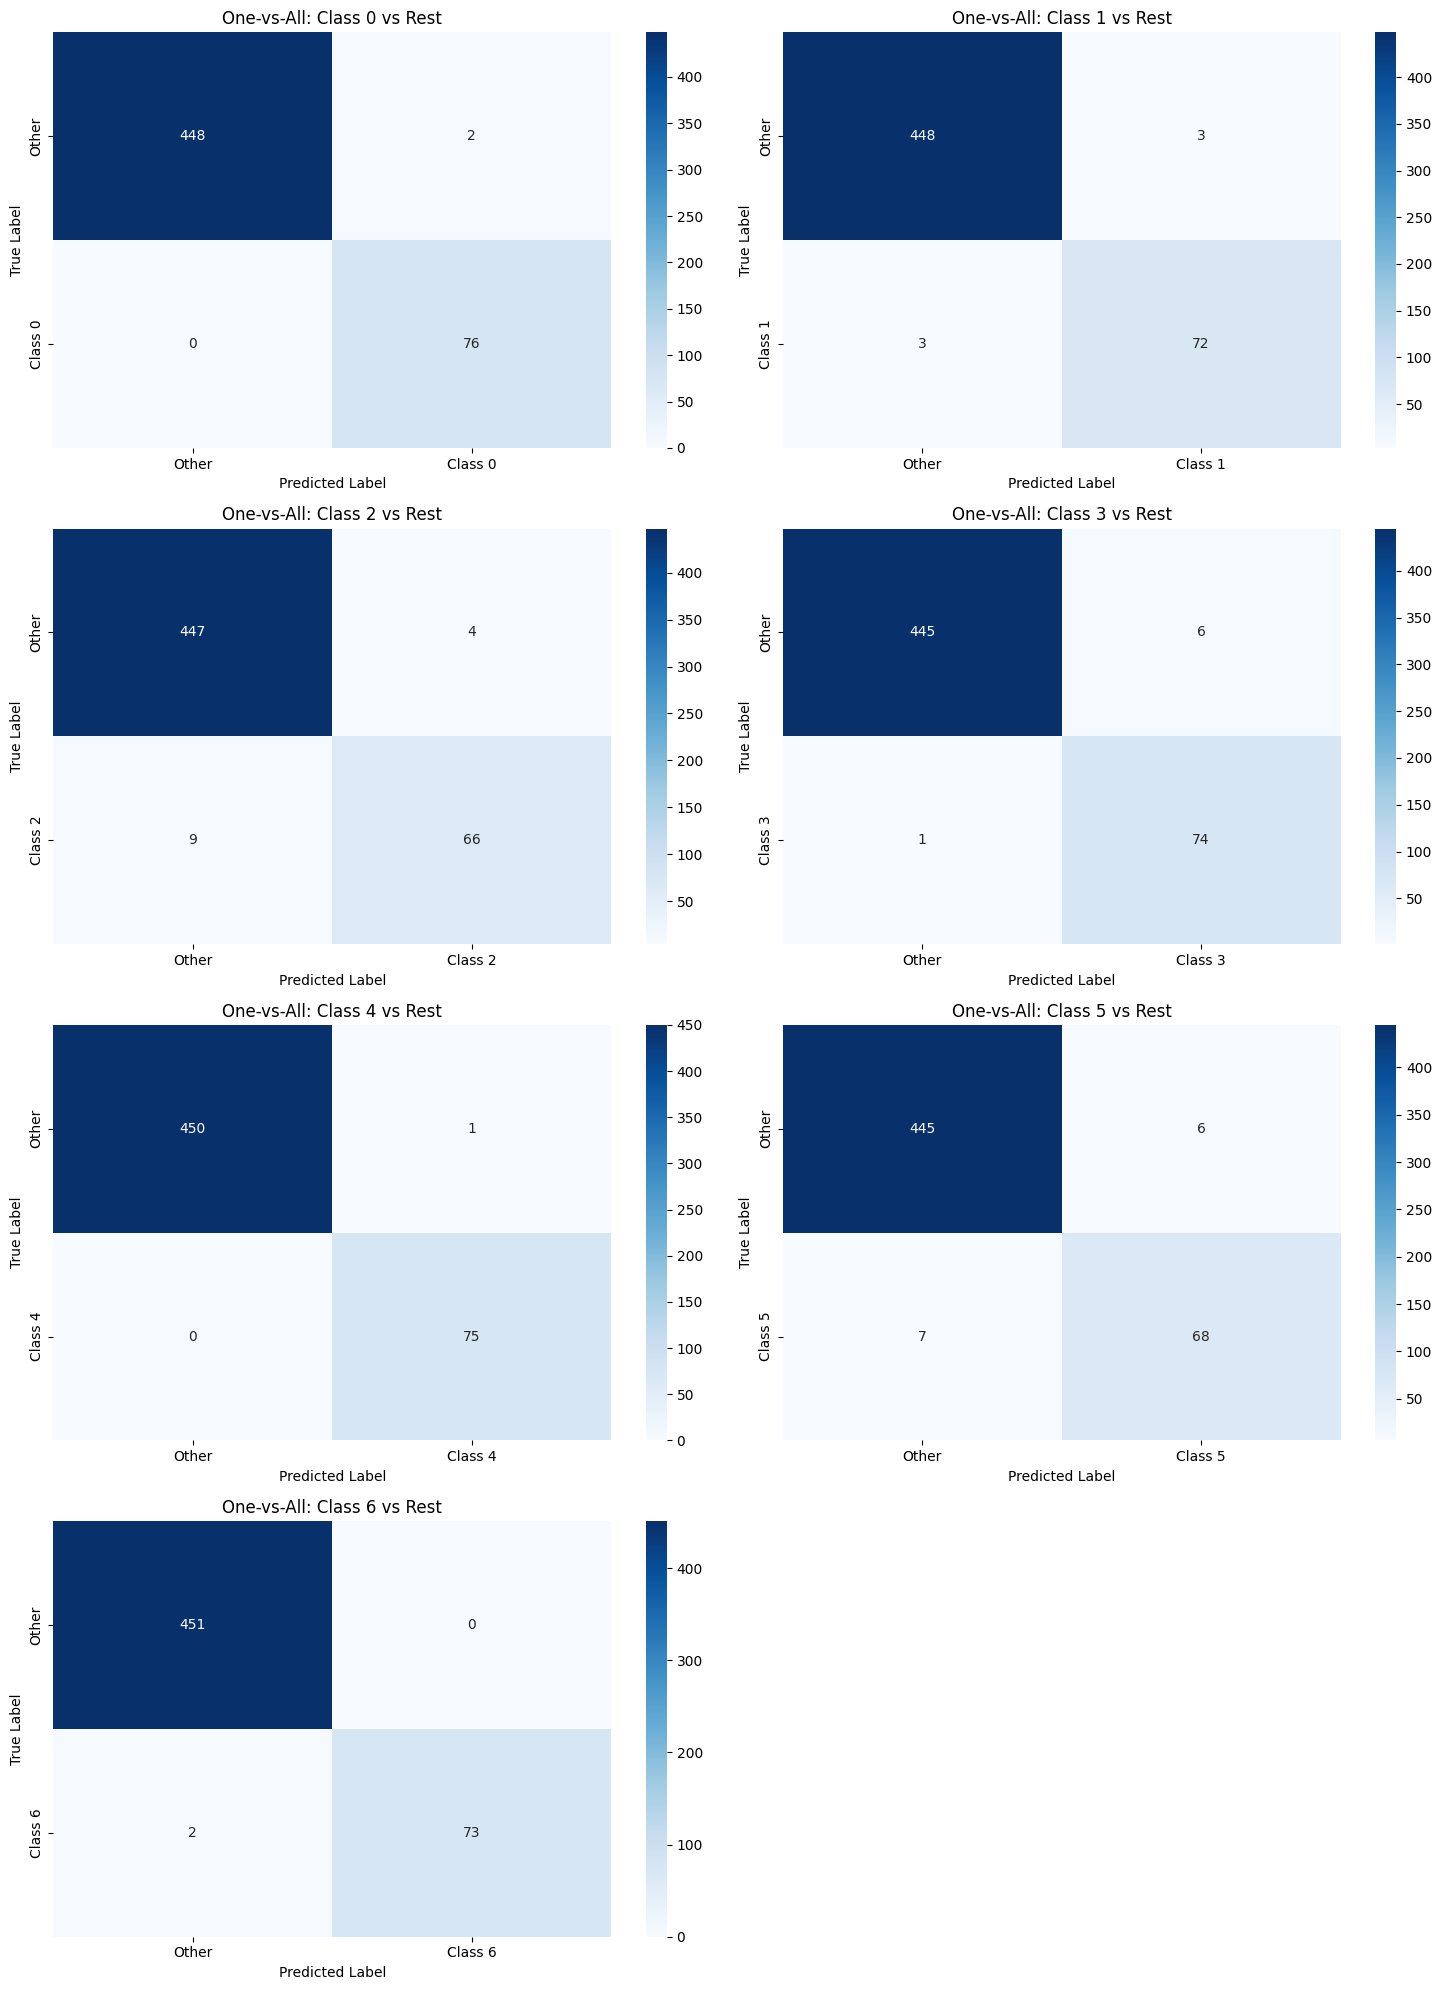

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming your custom generator is called 'test_generator'

# Get the true labels and predictions
y_true = []
y_pred = []

# Iterate through the entire dataset
for i in range(len(test_generator)):
    x, y = test_generator[i]
    batch_pred = model.predict(x)
    y_true.extend(np.argmax(y, axis=1))
    y_pred.extend(np.argmax(batch_pred, axis=1))

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Get the number of classes
num_classes = len(np.unique(y_true))

# Create one-vs-all confusion matrices
one_vs_all_cms = []

for i in range(num_classes):
    # Create binary classifications
    y_true_binary = (y_true == i).astype(int)
    y_pred_binary = (y_pred == i).astype(int)

    # Compute confusion matrix
    cm = confusion_matrix(y_true_binary, y_pred_binary)
    one_vs_all_cms.append(cm)

# Plot the one-vs-all confusion matrices
fig, axes = plt.subplots(nrows=(num_classes+1)//2, ncols=2, figsize=(15, 5*((num_classes+1)//2)))
axes = axes.flatten()

class_names = [f'Class {i}' for i in range(num_classes)]  # Replace with actual class names if available

for i, cm in enumerate(one_vs_all_cms):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=['Other', class_names[i]],
                yticklabels=['Other', class_names[i]])
    axes[i].set_title(f'One-vs-All: {class_names[i]} vs Rest')
    axes[i].set_ylabel('True Label')
    axes[i].set_xlabel('Predicted Label')

# Remove any unused subplots
for i in range(num_classes, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

## **Saving the model and class Mapping**

In [16]:
import os

# Specify the directory
save_dir = '/content/drive/MyDrive/medicinal_plants'

# Ensure the directory exists
os.makedirs(save_dir, exist_ok=True)

# Save the model
model_path = os.path.join(save_dir, 'dr_roots_model.h5')
model.save(model_path)

print(f"Model saved to {model_path}")

Model saved to /content/drive/MyDrive/medicinal_plants/dr_roots_model.h5


In [17]:
import json

# Save the class mapping
class_mapping_path = os.path.join(save_dir, 'class_mapping.json')
with open(class_mapping_path, 'w') as f:
    json.dump(idx_to_class, f)

print(f"Class mapping saved to {class_mapping_path}")

Class mapping saved to /content/drive/MyDrive/medicinal_plants/class_mapping.json


## **Testing Predictions**

Saving Vinca_Catharanthus_roseus_in_Bangladesh.jpg to Vinca_Catharanthus_roseus_in_Bangladesh.jpg
1/1 [==============================] - 0s 105ms/step
Predicted class: Catharanthus roseus
Confidence: 97.02%


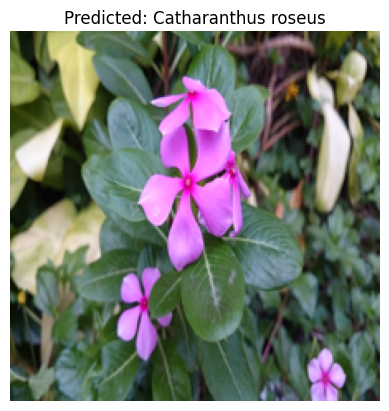

In [30]:
from google.colab import files
from PIL import Image
import io

def predict_uploaded_image(model, class_mapping):
    # Upload an image
    uploaded = files.upload()

    for fn in uploaded.keys():
        # Open the uploaded image
        image = Image.open(io.BytesIO(uploaded[fn]))

        # Preprocess the image
        image = image.resize((224, 224))
        image_array = np.array(image) / 255.0
        image_array = np.expand_dims(image_array, axis=0)

        # Make prediction
        prediction = model.predict(image_array)
        predicted_class = np.argmax(prediction, axis=1)[0]

        # Get the class name
        class_name = class_mapping[predicted_class]
        confidence = prediction[0][predicted_class] * 100

        print(f"Predicted class: {class_name}")
        print(f"Confidence: {confidence:.2f}%")

        # Display the image
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Predicted: {class_name}")
        plt.show()

# Use the function to predict an uploaded image
predict_uploaded_image(model, idx_to_class)

In [27]:
import tensorflow as tf

# Load your model
model = tf.keras.models.load_model("/content/drive/MyDrive/medicinal_plants/dr_roots_model.h5")

# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model
with open('/content/drive/MyDrive/medicinal_plants/dr_roots_model.tflite', 'wb') as f:
    f.write(tflite_model)